In [1]:
# Import Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for inline display in Jupyter
%matplotlib inline

In [4]:
# Step 1: Set Up Parameters

# Location coordinates for London
lat_ldn = 51.5074
lon_ldn = -0.1278
tz_ldn = "Europe/London"

# Location coordinates for Seattle
lat_sea = 47.6062
lon_sea = -122.3321
tz_sea = "America/Los_Angeles"

# Date range (full year of 2022)
start_date = '2022-01-01'
end_date = '2022-12-31'  

# Variables to fetch
hourly_variables = ['precipitation'] # mm per hour

In [5]:
# Step 2: Make the API Request

base_url = "https://archive-api.open-meteo.com/v1/archive"

def fetch_city_precip(lat, lon, tz, start_date, end_date, hourly_vars):
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(hourly_vars),
        "timezone": tz
    }
    response = requests.get(base_url, params=params, timeout=60)
    return response

resp_ldn = fetch_city_precip(lat_ldn, lon_ldn, tz_ldn, start_date, end_date, hourly_variables)
resp_sea = fetch_city_precip(lat_sea, lon_sea, tz_sea, start_date, end_date, hourly_variables)


In [7]:
# Check if the request was successful

if resp_ldn.status_code == 200 and resp_sea.status_code == 200:
    print("Data fetched successfully for both cities!")
else:
    print(f"London status: {resp_ldn.status_code}, Seattle status: {resp_sea.status_code}")

Data fetched successfully for both cities!


In [9]:
# Step 3: Load data into Pandas dataframe

# London
data_ldn = resp_ldn.json()
hourly_ldn = data_ldn["hourly"]
df_ldn = pd.DataFrame({
    "time": pd.to_datetime(hourly_ldn["time"]),
    "precipitation": pd.to_numeric(hourly_ldn["precipitation"], errors="coerce")
})
df_ldn.head()



,time,precipitation
0,2022-01-01 00:00:00,0.0
1,2022-01-01 01:00:00,0.0
2,2022-01-01 02:00:00,0.0
3,2022-01-01 03:00:00,0.0
4,2022-01-01 04:00:00,0.0


In [11]:
# Step 3: Load data into Pandas dataframe (contd..)

# Seattle
data_sea = resp_sea.json()
hourly_sea = data_sea["hourly"]
df_sea = pd.DataFrame({
    "time": pd.to_datetime(hourly_sea["time"]),
    "precipitation": pd.to_numeric(hourly_sea["precipitation"], errors="coerce")
})
df_sea.head()

,time,precipitation
0,2022-01-01 00:00:00,0.0
1,2022-01-01 01:00:00,0.0
2,2022-01-01 02:00:00,0.0
3,2022-01-01 03:00:00,0.0
4,2022-01-01 04:00:00,0.0


In [12]:
# Step 4: Data Cleaning

# Convert 'time' column to datetime index

# London
df_ldn = df_ldn.set_index("time").sort_index()
# Precipitation: fill missing with 0 (safe for accumulation)
df_ldn["precipitation"] = df_ldn["precipitation"].fillna(0)

# Seattle
df_sea = df_sea.set_index("time").sort_index()
df_sea["precipitation"] = df_sea["precipitation"].fillna(0)

# Quick missing values check
print("Missing (London):")
print(df_ldn.isnull().sum())
print("\nMissing (Seattle):")
print(df_sea.isnull().sum())


Missing (London):
precipitation    0
dtype: int64

Missing (Seattle):
precipitation    0
dtype: int64


In [14]:
# Handle missing values (if any)
df_ldn.fillna(method='ffill', inplace=True)  # Forward fill
df_sea.fillna(method='ffill', inplace=True)


C:\Users\Harmandeep Kaur\AppData\Local\Temp\ipykernel_83512\2983535497.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ldn.fillna(method='ffill', inplace=True)  # Forward fill
C:\Users\Harmandeep Kaur\AppData\Local\Temp\ipykernel_83512\2983535497.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sea.fillna(method='ffill', inplace=True)


In [22]:
# Step 5: Resample hourly to weekly

# Use a consistent week ending; W-SUN = weeks ending on Sunday
weekly_ldn = df_ldn.resample("W-SUN").sum().rename(columns={"precipitation":"London"})
weekly_sea = df_sea.resample("W-SUN").sum().rename(columns={"precipitation":"Seattle"})

# Combine for comparison (same index)
weekly_combined = weekly_ldn.join(weekly_sea, how="outer").fillna(0)
weekly_combined.head()


,London,Seattle
time,,
2022-01-02,2.2,31.3
2022-01-09,12.9,108.8
2022-01-16,3.1,45.5
2022-01-23,0.0,15.7
2022-01-30,0.1,6.1


In [23]:
# Step 6: EDA

df_ldn.describe()


,precipitation
count,8760.000000
mean,0.075662
std,0.404500
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,14.700000


In [24]:
df_sea.describe()

,precipitation
count,8760.000000
mean,0.129132
std,0.463708
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.700000


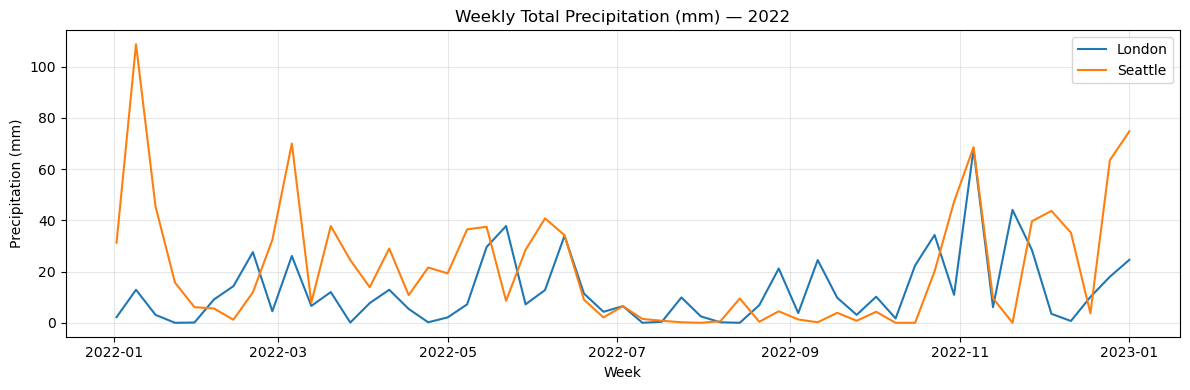

In [25]:
# Visualisation (weekly total rainfall)

plt.figure(figsize=(12,4))
plt.plot(weekly_combined.index, weekly_combined["London"], label="London")
plt.plot(weekly_combined.index, weekly_combined["Seattle"], label="Seattle")
plt.title("Weekly Total Precipitation (mm) — 2022")
plt.xlabel("Week")
plt.ylabel("Precipitation (mm)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Other Analysis

# Annual totals
totals_2022 = weekly_combined.sum().sort_values(ascending=False)
print("Total precipitation in 2022 (mm):")
print(totals_2022)

# Wettest 3 weeks per city (with week ending dates)
top3_ldn = weekly_ldn.sort_values("London", ascending=False).head(3)
top3_sea = weekly_sea.sort_values("Seattle", ascending=False).head(3)

print("\nLondon — Top 3 wettest weeks:")
display(top3_ldn)

print("\nSeattle — Top 3 wettest weeks:")
display(top3_sea)


Total precipitation in 2022 (mm):
Seattle    1131.2
London      662.8
dtype: float64

London — Top 3 wettest weeks:


,London
time,
2022-11-06,67.8
2022-11-20,44.1
2022-05-22,37.8



Seattle — Top 3 wettest weeks:


,Seattle
time,
2022-01-09,108.8
2023-01-01,74.8
2022-03-06,70.0


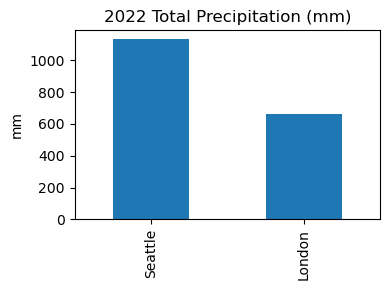

In [28]:
# Bar chart showing total precipitation in 2022 of both cities

ax = totals_2022.plot(kind="bar", figsize=(4,3), title="2022 Total Precipitation (mm)")
ax.set_ylabel("mm")
plt.tight_layout()
plt.show()

In [29]:
# Saving the files

weekly_combined.to_csv("weekly_precip_2022_london_vs_seattle.csv")
df_ldn.reset_index().to_csv("hourly_precip_2022_london.csv", index=False)
df_sea.reset_index().to_csv("hourly_precip_2022_seattle.csv", index=False)

### Analysis
In 2022, Seattle recorded about 1131 mm of rainfall compared to London’s 663 mm, making Seattle roughly 70% wetter overall. The weekly totals show that Seattle experiences intense rainfall spikes in winter and early spring (e.g., over 100 mm in early January), while its summers are relatively dry. London, on the other hand, shows more consistent but moderate rainfall spread across the year, with smaller peaks in May and November. Interestingly, both cities saw higher rainfall in late autumn (November), suggesting seasonal storm activity. Overall, Seattle’s rainfall pattern is more burst-like and seasonal, while London’s is steadier and less extreme.

Limitations: These results use open mateo data at city-center coordinates, which may not perfectly reflect official station measurements or account for local variations. Weekly aggregation also smooths out daily extremes.